# Setup

In [1]:
import os, math
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy.matlib as matlib
import pysindy as ps

from pandas import Series, DataFrame

import scipy
from scipy import signal, linalg, stats
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.ensemble import BaggingRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

import nitime.algorithms.spectral as spectrum
from nitime.viz import winspect, plot_spectral_estimate
import scipy.stats.distributions as dist

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import keras.backend as K

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

2023-02-20 19:18:42.452743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 19:18:42.576924: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-20 19:18:43.101064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-20 19:18:43.101125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [2130]:
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")
        
def scaler(data_in, scaler_in = None):

    if scaler_in is None:
        scaler_in = MinMaxScaler(feature_range=(-1, 1))
        scaler_in.fit(data_in)
        
    x = scaler_in.transform(data_in)
    x = StandardScaler(with_std=False).fit_transform(x)
    
    return x, scaler_in

def hankel_matrix(Xin, n_delay_coordinates, spacing=1):
    n_inputs, n_samples = Xin.shape

    X = np.zeros((n_inputs * (n_delay_coordinates), n_samples - spacing*(n_delay_coordinates-1)))
    for i in range(n_delay_coordinates):
        idxs = np.arange(spacing*i, spacing*(i+1) + n_samples - spacing*n_delay_coordinates)
        X[i*n_inputs:(i+1)*n_inputs] = Xin[:, idxs]
    return X

def true_polys(rows, dt, r, center): 
    m = rows // 2
    Ut = np.linspace(-m*dt, m*dt, rows)
    poly_stack = []
    for j in range(r):
        if (center):
            poly_stack.append(Ut ** (j + 1))
        else: 
            poly_stack.append(Ut ** j)
    poly_stack = np.vstack(poly_stack).T
    Q = np.empty((rows, r)) # Perform Gram-Schmidt
    for j in range(r): 
        v = poly_stack[:, j]
        for k in range(j - 1): 
            r_jk = Q[:, k].T @ poly_stack[:, j]
            v -= (r_jk * Q[:, k])
        r_jj = np.linalg.norm(v)
        Q[:, j] = v / r_jj
    return Q

def SVD_projection(data, rank=10):
    u, s, vh = np.linalg.svd(data, full_matrices=False)
    return vh[:rank,:]


In [2962]:
def MLP_predict(xtrain, ytrain, activation_in='tanh', alpha_in=.001):

    alpha = alpha_in
    in_dim = xtrain.shape[1]
    out_dim = ytrain.shape[1]
    model = Sequential()
    model.add(Dense(in_dim, input_dim=in_dim, activation=activation_in, activity_regularizer=regularizers.L2(l2=alpha), kernel_initializer='he_uniform'))
    #model.add(Dense(in_dim*2, activation=activation_in, activity_regularizer=regularizers.L2(l2=alpha), kernel_initializer='he_uniform'))
    model.add(Dense(out_dim, activation='linear', activity_regularizer=regularizers.L2(l2=alpha), kernel_initializer='he_uniform'))
    #model.add(Dropout(.1))

    opt = keras.optimizers.Adam(learning_rate=.02)
    model.compile(loss='mse', optimizer=opt)
    model.fit(xtrain, ytrain, epochs=100, batch_size=5000, verbose=0)#, validation_data=(xtrain[:-1000,:],ytrain[:-1000,:]))
    
    r_squared = r2_score(ytrain, model.predict(xtrain), multioutput = 'variance_weighted')
    
    return r_squared, model

In [2131]:
def process_rsData(session_data, use_all_neurons=True):
    rsData = StimulusSpecificData('spontaneous')

    """ resting-state info """
    stimTable = session_data.get_stimulus_table('spontaneous')
    rsData.stimTable = stimTable
    rsData.stimID = stimTable.index[-2]
    rsData.tstart = stimTable['start_time'].values[-2]
    rsData.tstop = stimTable['stop_time'].values[-2]
    rsData.tdur = stimTable['duration'].values[-2]


    """ process running data """
    running = session_data.running_speed
    stim_running = running[(running['start_time']>rsData.tstart) & (running['end_time']<rsData.tstop)]
    running_speed = stim_running.velocity.values
    running_time = stim_running.iloc[:,0:2].mean(axis=1) - rsData.tstart
    # 793224716 gets a outlier
    running_speed[running_speed < -90 * running_speed.std()] = 0
    rsData.running_speed = running_speed
    rsData.running_time = running_time.values

    """ process pupil data """
    pupil = session_data.get_pupil_data()
    stim_pupil = pupil[(pupil.index>rsData.tstart) & (pupil.index<rsData.tstop)]
    stim_pupil.index = stim_pupil.index - rsData.tstart

    pupil_size = stim_pupil.loc[:, ['pupil_height', 'pupil_width']].mean(axis=1).values
    pupil_time = stim_pupil.index.values

    rsData.pupil_data = stim_pupil
    rsData.pupil_size = pupil_size
    rsData.pupil_time = pupil_time

    return rsData

In [2644]:
from ripple_detection import Kay_ripple_detector
def process_lfpData(session_data, rsData):

    lfpData = DataContainer()

    probesid = session_data.probes.index.values
    #probesid = probesid[5:]
    sr = session_data.probes.lfp_sampling_rate.values[0]    

    lfp_time = None
    t_pad = 0

    rs_lfpCA1 = list()
    rs_lfpVIS = list()
    for pid in probesid:
        print('processing lfp data for probe-{:d}'.format(pid))
        try:
            rs_lfp = session_data.get_lfp(pid).sel(time=slice(rsData.tstart-t_pad, rsData.tstop+t_pad))
        except ValueError:
            print('Probe does not exist')
            continue
        
        rs_lfp = rs_lfp.assign_coords(time = rs_lfp.time - rsData.tstart)

        rs_lfp = rs_lfp.interpolate_na(dim="time",method="linear")
        
        chnid = rs_lfp.channel.values
        try:
            chnloc = channels.loc[chnid, 'ecephys_structure_acronym']
        except:
            print("missing channel!")
            continue
            
        rs_lfp = rs_lfp.drop_sel(channel=chnid[np.where(chnloc.str.match('NaN'))])
        chnid = rs_lfp.channel.values
        chnloc = channels.loc[chnid, 'ecephys_structure_acronym']
        
        if lfp_time is not None:
            intp = interp1d(rs_lfp.time.values.T, rs_lfp.values.T)
            sig_intp = intp(lfp_time.values).T
            rs_lfp = xr.DataArray(sig_intp, coords=[lfp_time, rs_lfp.channel])
        else:
            lfp_time = rs_lfp.time
            t_pad = 1
        
        rs_lfpCA1.append(rs_lfp.sel(channel=chnid[np.where(chnloc.str.match('CA1'))]))
        rs_lfpVIS.append(rs_lfp.sel(channel=chnid[np.where(chnloc.str.match('VIS'))]))

    rs_lfpCA1 = xr.concat(rs_lfpCA1, dim="channel")
    rs_lfpVIS = xr.concat(rs_lfpVIS, dim="channel")


    #rs_lfpCA1 = rs_lfpCA1.fillna(0)
    #rs_lfpVIS = rs_lfpVIS.fillna(0)


    lfpData.probesid = probesid
    lfpData.sr = sr
    lfpsr = lfpData.sr

    CA1chn = rs_lfpCA1.channel.values
    CA1time = lfp_time.values
    lfpData.CA1chn = CA1chn
    lfpData.CA1time = CA1time

    lfpData.rs_lfpVIS = rs_lfpVIS
    lfpData.rs_lfpCA1 = rs_lfpCA1
    
    speed = np.ones_like(lfpData.CA1time)
    ripple_times = Kay_ripple_detector(lfpData.CA1time, rs_lfpCA1.values.copy(), speed, lfpData.sr)
    
    ripples = ripple_times.end_time

    ripple_time = np.linspace(lfpData.CA1time[0],lfpData.CA1time[-1],int(np.ceil(5*(lfpData.CA1time[-1]-lfpData.CA1time[0]))))
    ripple_rate = np.empty(ripple_time.size)
    for i in range(ripple_rate.size-1):
        ripple_rate[i] = len(ripples[(ripples>ripple_time[i])&(ripples<ripple_time[i+1])])
    ripple_rate = scipy.ndimage.gaussian_filter1d(ripple_rate,10)

    sos_swr = signal.butter(2, .2, output = 'sos', fs = lfpsr)
    lfpData.ripple_rate = ripple_rate
    lfpData.ripple_time = ripple_time
    #lfpData.ripple_rate = signal.sosfiltfilt(sos_swr, ripple_rate, axis = 0)
    
    return lfpData

In [2623]:
def compute_obs(rsData, lfpData):
    
    ## Compute BLPs
    lfp = lfpData.rs_lfpVIS
    sos_delta = signal.butter(10, [.5, 4], 'bp', output = 'sos', fs = lfpData.sr)
    sos_alpha = signal.butter(10, [2, 10], 'bp', output = 'sos', fs = lfpData.sr)
    sos_gamma = signal.butter(10, [40, 100], 'bp', output = 'sos', fs = lfpData.sr)
    sos_env = signal.butter(2, [.002,.2], 'bp', output = 'sos', fs = lfpData.sr)

    # DELTA
    delta_blp = signal.sosfiltfilt(sos_delta, lfp, axis = 0)
    delta_blp = signal.decimate(delta_blp,6,axis=0)
    delta_blp = np.sqrt(scipy.ndimage.gaussian_filter1d(np.square(delta_blp),1000,axis=0))
    delta_blp = signal.resample(delta_blp,len(rsData.pupil_size))
    delta_mean = np.mean(delta_blp, axis=1)

    # ALPHA
    alpha_blp = signal.sosfiltfilt(sos_alpha, lfp, axis = 0)
    alpha_blp = signal.decimate(alpha_blp,6,axis=0)
    alpha_blp = np.sqrt(scipy.ndimage.gaussian_filter1d(np.square(alpha_blp),1000,axis=0))
    alpha_blp = signal.resample(alpha_blp,len(rsData.pupil_size))
    alpha_mean = np.mean(alpha_blp, axis=1)

    # GAMMA
    gamma_blp = signal.sosfiltfilt(sos_gamma, lfp, axis = 0)
    gamma_blp = signal.decimate(gamma_blp,6,axis=0)
    gamma_blp = np.sqrt(scipy.ndimage.gaussian_filter1d(np.square(gamma_blp),1000,axis=0))
    gamma_blp = signal.resample(gamma_blp,len(rsData.pupil_size))
    gamma_mean = np.mean(gamma_blp, axis=1)

    ## Hippocampal theta
    lfp = lfpData.rs_lfpCA1
    sos_delta = signal.butter(10, [1, 4], 'bp', output = 'sos', fs = lfpData.sr)
    sos_theta = signal.butter(10, [5, 9], 'bp', output = 'sos', fs = lfpData.sr)

    theta_blp = signal.sosfiltfilt(sos_theta, lfp, axis = 0)
    theta_blp = signal.decimate(theta_blp,6,axis=0)
    theta_blp = np.sqrt(scipy.ndimage.gaussian_filter1d(np.square(theta_blp),1000,axis=0))
    theta_blp = signal.resample(theta_blp,len(rsData.pupil_size))
    theta_mean = np.mean(theta_blp, axis=1)
    
    hc_delta_blp = signal.sosfiltfilt(sos_delta, lfp, axis = 0)
    hc_delta_blp = signal.decimate(hc_delta_blp,6,axis=0)
    hc_delta_blp = np.sqrt(scipy.ndimage.gaussian_filter1d(np.square(hc_delta_blp),1000,axis=0))
    hc_delta_blp = signal.resample(hc_delta_blp,len(rsData.pupil_size))
    hc_delta_mean = np.mean(hc_delta_blp, axis=1)

    ## SWRs
    ripple_rate = signal.resample(lfpData.ripple_rate,len(rsData.pupil_size))
    ripple_rate = scipy.ndimage.gaussian_filter1d(ripple_rate,100)

    ## run_speed
    run_speed = signal.resample(np.convolve(rsData.running_speed,np.ones(1,dtype=int),'same'), len(rsData.pupil_size)) #100

    ## store
    obs = np.zeros([len(rsData.pupil_size),8])
    x = Series(rsData.pupil_size).interpolate().values
    x = signal.medfilt(x,11)
    x = x / np.max(x)
    pupil_clean = signal.detrend(x)
    obs[:,0] = pupil_clean
    obs[:,1] = run_speed
    obs[:,2] = theta_mean
    obs[:,3] = ripple_rate
    obs[:,4] = delta_mean
    obs[:,5] = gamma_mean
    obs[:,6] = alpha_mean
    obs[:,7] = hc_delta_mean
    
    return obs

# Compute and save observables for each session

In [2742]:
# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join("./ecephys_cache_dir/", "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
channels = cache.get_channels()
units = cache.get_units()
session_IDs = sessions[sessions['session_type']=='functional_connectivity'].index.values

# remove sessions without eye tracking
mask = np.ones(len(session_IDs), dtype=bool)
mask[2] = False
mask[23] = False
session_IDs = session_IDs[mask]

In [ ]:
for session_id in session_IDs:

    session = cache.get_session_data(session_id)  
    
    print('Processing session ' + str(session_id) + '...')

    tic()
    #rsData = process_rsData(session)
    lfpData = process_lfpData(session,rsData)
    toc()
    
    print('Computing observables')
    tic()
    obs = compute_obs(rsData, lfpData)
    toc()
    
    np.save('./ecephys_cache_dir/' + str(session_id) + '_obs', obs)
    
    print('Finished processing session ' + str(session_id))

In [2294]:
session_id

array([766640955, 767871931, 771160300, 771990200, 774875821, 778240327,
       778998620, 779839471, 781842082, 786091066, 787025148, 789848216,
       793224716, 794812542, 816200189, 819186360, 819701982, 821695405,
       829720705, 831882777, 835479236, 839068429, 839557629, 840012044,
       847657808])

In [2991]:
def VAE(xtrain, ytrain, latent_dim=3, beta=.1, num_epochs=1000):
    
    from keras import backend as K
    from keras.layers import Dense, Dropout, Input, Layer
        
    input_dim = xtrain.shape[1]
    output_dim = ytrain.shape[1]
    input_data = keras.Input(shape=(input_dim,))
    
    class Sampling(Layer):
        """Uses (z_mean, z_log_var) to sample z"""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * .1*epsilon
            
    encoded = Dense(latent_dim, activation='tanh')(input_data)
    z_mean = Dense(latent_dim, name="z_mean")(input_data)
    z_log_var = Dense(latent_dim, name="z_log_var")(input_data)
    z = Sampling()([z_mean, z_log_var])
    latent_inputs = keras.Input(shape=(latent_dim,))
    decoded = Dense(output_dim, activation='tanh')(latent_inputs)
    decoded = Dense(output_dim, activation='linear')(decoded)
    
    encoder = keras.Model(input_data, [z_mean, z_log_var, z], name="encoder")
    #encoder.load_weights("test_encoder_weights.h5")
    #for layer in encoder.layers:
        #layer.trainable = False
    decoder = keras.Model(latent_inputs, decoded, name="decoder")
    
    
    class VAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            
            data1, data2 = data
            
            with tf.GradientTape() as tape:
                
                z_mean, z_log_var, z = self.encoder(data1)
                
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(keras.losses.mse(data2, reconstruction),0)

                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(kl_loss,0)

                total_loss = reconstruction_loss + beta*kl_loss
                
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
        
        def predict(self, data):
            z_mean,z_log_var,z = self.encoder(data)
            decoded = self.decoder(z_mean)
            return decoded
            
    vae = VAE(encoder, decoder)
    opt = keras.optimizers.Adam(learning_rate=.02)
    vae.compile(optimizer=opt)
    vae.fit(xtrain, ytrain, epochs=num_epochs, batch_size=5000, verbose=False)
        
    r_squared = r2_score(ytrain, vae.predict(xtrain), multioutput = 'variance_weighted')

    return r_squared, vae, encoder, decoder

# Delay embedding

In [ ]:
## GROUP

stackmax = 150
spacing = 6
r = 10
Fs = 30

sos = signal.butter(2, [.002,.2], btype = 'bandpass', output = 'sos', fs = 30)
polys = true_polys(stackmax, 1/Fs, r, center=False)

xtrain = np.empty((0,r))
ytrain = np.empty((0,7))

for session_id in session_IDs[:10]:
    obs = np.load('./ecephys_cache_dir/' + str(session_id) + '_obs.npy')
    x = signal.sosfiltfilt(sos, obs[:,0:1], axis=0)
    y = signal.sosfiltfilt(sos, obs, axis=0)

    Hp = hankel_matrix(x.T,stackmax,spacing)
    
    xtrain = np.concatenate((xtrain, (polys.T@Hp).T), axis=0)
    ytrain = np.concatenate((ytrain, y[spacing*(stackmax-1):,:]), axis=0)

In [2722]:
## INDIVIDUAL

session_id = session_IDs[2]
obs = np.load('./ecephys_cache_dir/' + str(session_id) + '_obs.npy')

## DELAY EMBED
stackmax = 150
spacing = 6
r = 10
Fs = 30
lag = 1 # in seconds
lag = lag*Fs*spacing

sos = signal.butter(2, [.002,.2], btype = 'bandpass', output = 'sos', fs = 30)
x = signal.sosfiltfilt(sos, obs[:,0:1], axis=0)
y = signal.sosfiltfilt(sos, obs, axis=0)
y[:,-1] = y[:,2]/y[:,-1]

Hp = hankel_matrix(x.T,stackmax,spacing)
Hpu, Hps, Hpvh = np.linalg.svd(Hp, full_matrices=False)
polys = true_polys(stackmax, 1/Fs, r+2, center=False)

xtrain = (polys.T@Hp).T
ytrain = y[spacing*(stackmax-1):,:]

xtrain = xtrain[lag:,:]
ytrain = ytrain[:-lag,:]

In [2723]:
# CROSS VAL

# Loop over K folds
nsplits = 3
kf = KFold(n_splits=nsplits, shuffle=False)    

decoders = []
kf_scores = np.zeros((nsplits, 7))
for i, (train_idx, test_idx) in enumerate(kf.split(xtrain)):

    print(f'Fold {i+1}')

    test_idx = test_idx[spacing*(stackmax-1):-spacing*(stackmax-1)]

    train_x, train_y = xtrain[train_idx], ytrain[train_idx]
    test_x, test_y = xtrain[test_idx], ytrain[test_idx]

    train_x, scale_x = scaler(train_x)
    train_y, scale_y = scaler(train_y)

    r_squared, model, encoder, decoder = VAE(train_x, train_y, 2, .1, num_epochs=200)

    test_x,_ = scaler(test_x, scale_x)
    test_y,_ = scaler(test_y, scale_y)
    test_y_hat = model.predict(test_x)
    test_y_hat = scale_y.inverse_transform(test_y_hat)
    test_y = scale_y.inverse_transform(test_y)

    for j in range(kf_scores.shape[1]):
        kf_scores[i,j] = r2_score(test_y[:,j], test_y_hat[:,j])

    decoders.append(decoder)

kf_scores

Fold 1
Epoch 1/200
8/8 [==============================] - 0s 4ms/step - loss: 0.1295 - reconstruction_loss: 0.1156 - kl_loss: 0.0539
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0930 - reconstruction_loss: 0.0820 - kl_loss: 0.0308
Epoch 3/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0660 - reconstruction_loss: 0.0618 - kl_loss: 0.0333
Epoch 4/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0628 - reconstruction_loss: 0.0581 - kl_loss: 0.0412
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0605 - reconstruction_loss: 0.0564 - kl_loss: 0.0410
Epoch 6/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0593 - reconstruction_loss: 0.0554 - kl_loss: 0.0391
Epoch 7/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0585 - reconstruction_loss: 0.0542 - kl_loss: 0.0394
Epoch 8/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0581 - reconstruction_loss: 0.0538 - k

8/8 [==============================] - 0s 5ms/step - loss: 0.0507 - reconstruction_loss: 0.0443 - kl_loss: 0.0616
Epoch 130/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0502 - reconstruction_loss: 0.0442 - kl_loss: 0.0622
Epoch 131/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0503 - reconstruction_loss: 0.0440 - kl_loss: 0.0606
Epoch 132/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0504 - reconstruction_loss: 0.0445 - kl_loss: 0.0603
Epoch 133/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0507 - reconstruction_loss: 0.0441 - kl_loss: 0.0612
Epoch 134/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0506 - reconstruction_loss: 0.0443 - kl_loss: 0.0616
Epoch 135/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0506 - reconstruction_loss: 0.0445 - kl_loss: 0.0603
Epoch 136/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0504 - reconstruction_loss: 0.0441 - kl_los

8/8 [==============================] - 0s 5ms/step - loss: 0.0565 - reconstruction_loss: 0.0515 - kl_loss: 0.0488
Epoch 58/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0564 - reconstruction_loss: 0.0519 - kl_loss: 0.0473
Epoch 59/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0565 - reconstruction_loss: 0.0522 - kl_loss: 0.0479
Epoch 60/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0563 - reconstruction_loss: 0.0513 - kl_loss: 0.0482
Epoch 61/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0566 - reconstruction_loss: 0.0519 - kl_loss: 0.0489
Epoch 62/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0566 - reconstruction_loss: 0.0514 - kl_loss: 0.0490
Epoch 63/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0566 - reconstruction_loss: 0.0518 - kl_loss: 0.0491
Epoch 64/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0562 - reconstruction_loss: 0.0514 - kl_loss: 0.04

8/8 [==============================] - 0s 5ms/step - loss: 0.0545 - reconstruction_loss: 0.0486 - kl_loss: 0.0593
Epoch 186/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0546 - reconstruction_loss: 0.0490 - kl_loss: 0.0587
Epoch 187/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0550 - reconstruction_loss: 0.0487 - kl_loss: 0.0595
Epoch 188/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0548 - reconstruction_loss: 0.0489 - kl_loss: 0.0592
Epoch 189/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0551 - reconstruction_loss: 0.0493 - kl_loss: 0.0596
Epoch 190/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0549 - reconstruction_loss: 0.0490 - kl_loss: 0.0580
Epoch 191/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0549 - reconstruction_loss: 0.0489 - kl_loss: 0.0589
Epoch 192/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0547 - reconstruction_loss: 0.0490 - kl_los

8/8 [==============================] - 0s 6ms/step - loss: 0.0498 - reconstruction_loss: 0.0440 - kl_loss: 0.0595
Epoch 114/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0498 - reconstruction_loss: 0.0438 - kl_loss: 0.0595
Epoch 115/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0498 - reconstruction_loss: 0.0437 - kl_loss: 0.0590
Epoch 116/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0497 - reconstruction_loss: 0.0442 - kl_loss: 0.0605
Epoch 117/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0502 - reconstruction_loss: 0.0437 - kl_loss: 0.0600
Epoch 118/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0501 - reconstruction_loss: 0.0440 - kl_loss: 0.0593
Epoch 119/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0497 - reconstruction_loss: 0.0436 - kl_loss: 0.0603
Epoch 120/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0498 - reconstruction_loss: 0.0438 - kl_los

array([[ 8.95620301e-01,  6.62222132e-01,  2.01736962e-01,
         5.92813481e-01,  4.47078560e-01,  8.64719042e-01,
         3.16141991e-01],
       [ 9.53410446e-01,  7.68514351e-01,  1.39173967e-01,
         5.51321653e-01,  6.52337330e-01,  9.28517035e-01,
         4.96561197e-01],
       [ 7.97269941e-01, -1.00814692e+02,  9.41739667e-02,
         2.63822943e-01,  1.90139029e-01, -4.17613211e-01,
         2.21868316e-01]])

In [3051]:
# GROUP CROSS VAL

sessions = session_IDs[:]
num_sessions = len(sessions)

kf_scores_grp = np.zeros((num_sessions, nsplits, 7))

decoders = []

s=0
for session_id in sessions:
    
    obs = np.load('./ecephys_cache_dir/' + str(session_id) + '_obs.npy')
    obs[:,2] = obs[:,2]/obs[:,-1]
    
    ## DELAY EMBED
    stackmax = 50
    spacing = 6
    r = 3
    Fs = 30
    lag = 1 # in seconds
    lag = lag*Fs*spacing

    sos = signal.butter(2, [.002,.2], btype = 'bandpass', output = 'sos', fs = 30)
    x = signal.sosfiltfilt(sos, obs[:,0:1], axis=0)
    y = signal.sosfiltfilt(sos, obs, axis=0)
    #y[:,2] = y[:,2]/y[:,-1]

    Hp = hankel_matrix(x.T,stackmax,spacing)
    #Hpu, Hps, Hpvh = np.linalg.svd(Hp, full_matrices=False)
    polys = true_polys(stackmax, 1/Fs, r, center=False)

    xtrain = (polys.T@Hp).T
    xtrain = obs[spacing*(stackmax-1):,0:1]
    #xtrain = Hpvh[:r,:].T
    ytrain = y[spacing*(stackmax-1):,:]

    xtrain = xtrain[lag:,:]
    ytrain = ytrain[:-lag,:]
    
    # Loop over K folds
    nsplits = 3
    kf = KFold(n_splits=nsplits, shuffle=False)    

    #kf_scores = np.zeros((nsplits, 7))
    for i, (train_idx, test_idx) in enumerate(kf.split(xtrain)):

        print(f'Fold {i+1}')

        test_idx = test_idx[spacing*(stackmax-1):-spacing*(stackmax-1)]

        train_x, train_y = xtrain[train_idx], ytrain[train_idx]
        test_x, test_y = xtrain[test_idx], ytrain[test_idx]

        train_x, scale_x = scaler(train_x)
        train_y, scale_y = scaler(train_y)

        #r_squared, model, encoder, decoder = VAE(train_x, train_y, 2, .1, num_epochs=100)
        r_squared, model = MLP_predict(train_x, train_y, activation_in='tanh', alpha_in=.001)

        test_x,_ = scaler(test_x, scale_x)
        test_y,_ = scaler(test_y, scale_y)
        test_y_hat = model.predict(test_x)
        test_y_hat = scale_y.inverse_transform(test_y_hat)
        test_y = scale_y.inverse_transform(test_y)

        for j in range(kf_scores_grp.shape[-1]):
            kf_scores_grp[s,i,j] = r2_score(test_y[:,j], test_y_hat[:,j])

        decoders.append(model)
                
    #kf_scores_grp[s,:] = np.mean(kf_scores,axis=0)
    
    s+=1
    
    print('FINISHED ' + str(s) + '/' + str(num_sessions))

    #kf_scores

Fold 1
540/540 [==============================] - 1s 2ms/step
Fold 2
540/540 [==============================] - 1s 2ms/step
Fold 3
540/540 [==============================] - 1s 2ms/step
FINISHED 1/24
Fold 1
540/540 [==============================] - 1s 2ms/step
Fold 2
540/540 [==============================] - 1s 2ms/step
Fold 3
540/540 [==============================] - 1s 2ms/step
FINISHED 2/24
Fold 1
540/540 [==============================] - 1s 2ms/step
Fold 2
540/540 [==============================] - 1s 2ms/step
Fold 3
540/540 [==============================] - 1s 2ms/step
FINISHED 3/24
Fold 1
540/540 [==============================] - 1s 2ms/step
Fold 2
540/540 [==============================] - 1s 2ms/step
Fold 3
540/540 [==============================] - 1s 2ms/step
FINISHED 4/24
Fold 1
540/540 [==============================] - 1s 2ms/step
Fold 2
540/540 [==============================] - 1s 2ms/step
Fold 3
540/540 [==============================] - 1s 2ms/step
FINISHED 5/24


<IPython.core.display.Javascript object>


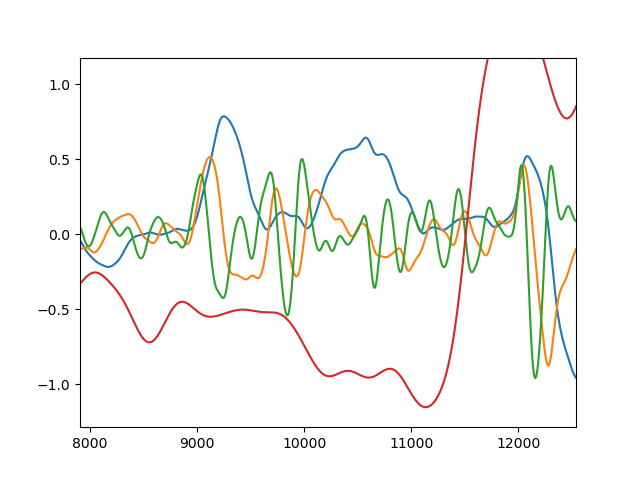

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got [0, 5]

In [3021]:
fig,ax = plt.subplots()
plt.plot(test_x[:,:])
plt.plot(500000*test_y[:,5])
plt.plot(model.predict(test_x)[:,[0,5]])
#plt.plot(encoder.predict(test_x)[0][:,:2])
#plt.plot(100*np.diff(xtrain[:,0]))
#plt.plot(xtrain[:,1])
plt.show()

<IPython.core.display.Javascript object>


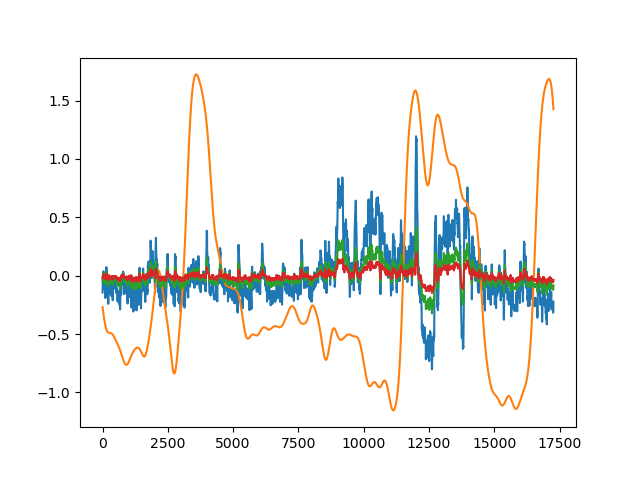

540/540 [==============================] - 1s 2ms/step


In [3057]:
fig,ax = plt.subplots()
plt.plot(test_x[:,:])
plt.plot(500000*test_y[:,5])
plt.plot(model.predict(test_x)[:,[0,5]])
#plt.plot(encoder.predict(test_x)[0][:,:2])
#plt.plot(100*np.diff(xtrain[:,0]))
#plt.plot(xtrain[:,1])
plt.show()

<IPython.core.display.Javascript object>


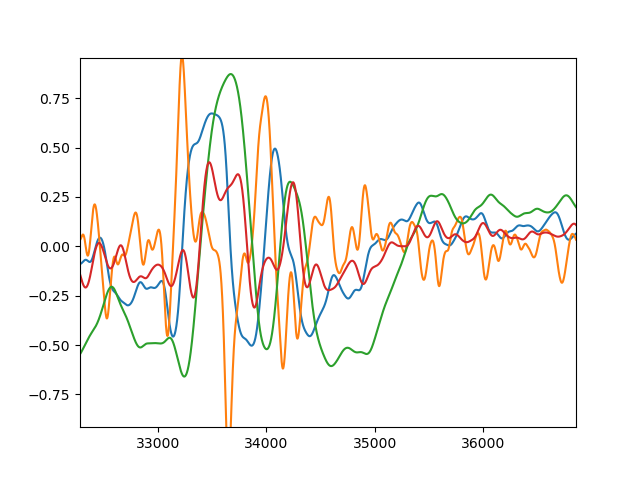

In [2883]:
fig,ax = plt.subplots()
plt.plot(temp[:,0])
plt.plot(100*np.diff(temp[:,0]))
plt.plot(temp[:,1])
plt.plot(temp[:,2])
plt.show()

<IPython.core.display.Javascript object>


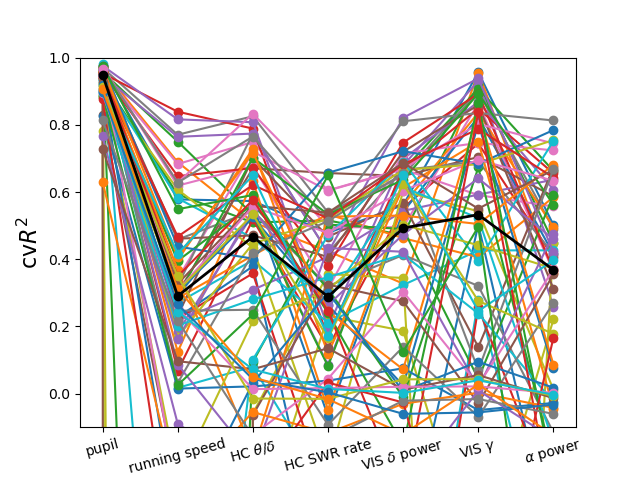

In [3015]:
fig, ax = plt.subplots()
titles = ['pupil', 'running speed', r'HC $\theta/\delta$', 'HC SWR rate',
          'VIS $\delta$ power', 'VIS $\gamma$', r'$\alpha$ power']

plt.plot(kf_scores_grp.reshape(nsplits*num_sessions,7).T, markersize=12, marker = '.')
plt.plot(np.median(kf_scores_grp.reshape(nsplits*num_sessions,7),axis=0), markersize=12, marker = '.', lw=2, color='k')
ax.set_xticks(np.arange(7), labels = titles, rotation=15)
ax.set_ylabel('cv$R^2$', fontsize=16)
ax.set_ylim([-.1,1])

plt.show()


<IPython.core.display.Javascript object>


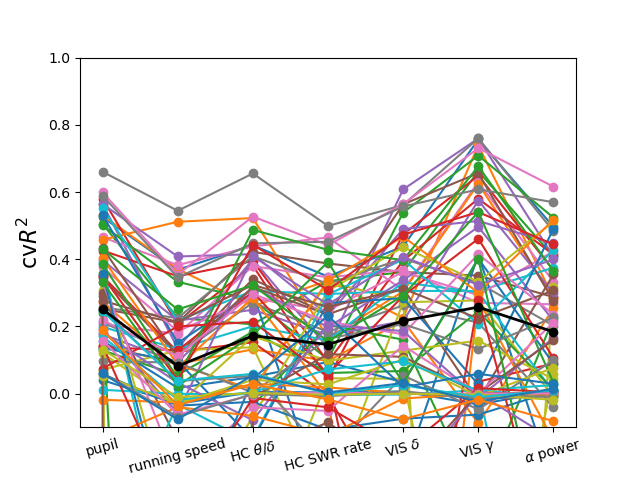

In [3058]:
fig, ax = plt.subplots()
titles = ['pupil', 'running speed', r'HC $\theta/\delta$', 'HC SWR rate',
          'VIS $\delta$', 'VIS $\gamma$', r'$\alpha$ power']

plt.plot(kf_scores_grp.reshape(nsplits*num_sessions,7).T, markersize=12, marker = '.')
plt.plot(np.median(kf_scores_grp.reshape(nsplits*num_sessions,7),axis=0), markersize=12, marker = '.', lw=2, color='k')
ax.set_xticks(np.arange(7), labels = titles, rotation=15)
ax.set_ylabel('cv$R^2$', fontsize=16)
ax.set_ylim([-.1,1])

plt.show()


<IPython.core.display.Javascript object>


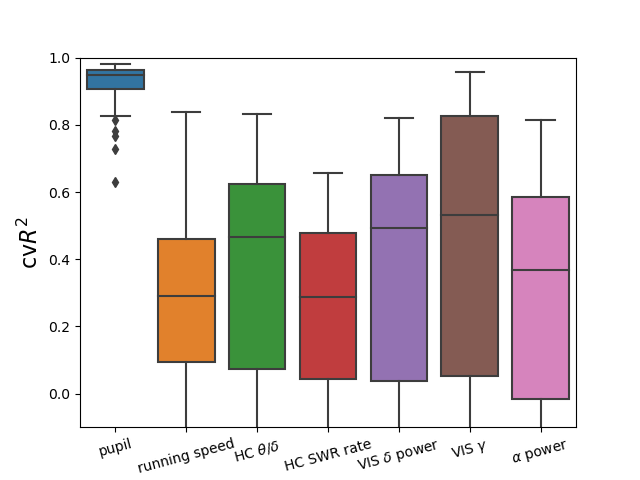

In [3016]:
import seaborn as sns

# Create a violin plot using seaborn
fig,ax = plt.subplots()
sns.boxplot(data=DataFrame(kf_scores_grp.reshape(nsplits*num_sessions,7)))
#sns.boxplot(data=DataFrame(np.median(kf_scores_grp,axis=1)))
ax.set_xticks(np.arange(7), labels = titles, rotation=15)
ax.set_ylabel('cv$R^2$', fontsize=16)
ax.set_ylim([-.1,1])


# Show the plot
plt.show()

<IPython.core.display.Javascript object>


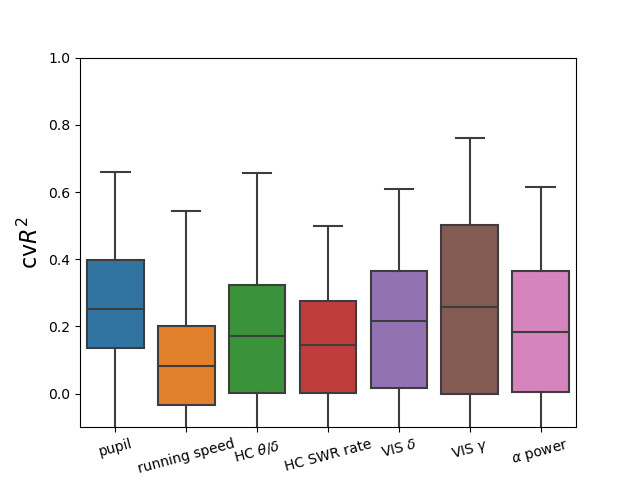

In [3055]:
import seaborn as sns

# Create a violin plot using seaborn
fig,ax = plt.subplots()
sns.boxplot(data=DataFrame(kf_scores_grp.reshape(nsplits*num_sessions,7)))
#sns.boxplot(data=DataFrame(np.median(kf_scores_grp,axis=1)))
ax.set_xticks(np.arange(7), labels = titles, rotation=15)
ax.set_ylabel('cv$R^2$', fontsize=16)
ax.set_ylim([-.1,1])


# Show the plot
plt.show()

<IPython.core.display.Javascript object>


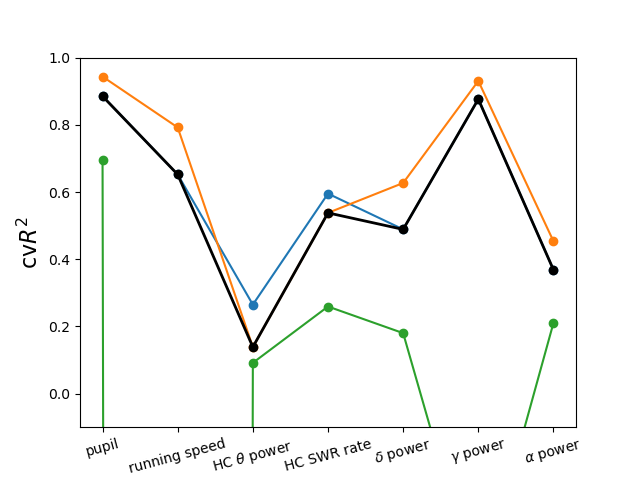

In [2718]:
fig, ax = plt.subplots()
titles = ['pupil', 'running speed', r'HC $\theta$ power', 'HC SWR rate',
          '$\delta$ power', '$\gamma$ power', r'$\alpha$ power']

plt.plot(kf_scores.T, markersize=12, marker = '.')
plt.plot(np.median(kf_scores,axis=0), markersize=12, marker = '.', lw=2, color='k')
ax.set_xticks(np.arange(7), labels = titles, rotation=15)
ax.set_ylabel('cv$R^2$', fontsize=16)
ax.set_ylim([-.1,1])

plt.show()

<IPython.core.display.Javascript object>


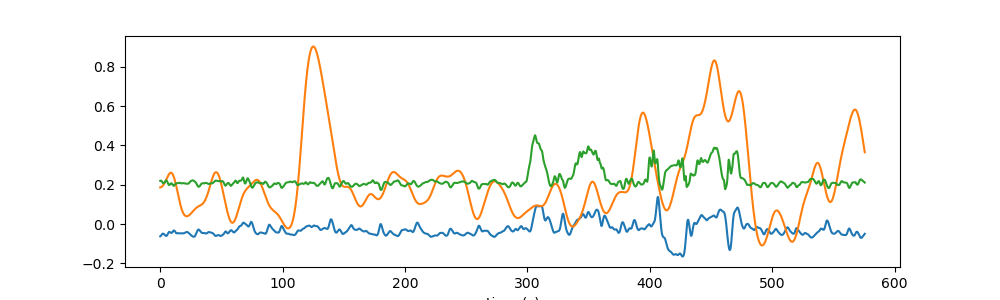

In [2877]:
j = 2


t = np.linspace(0, test_y.shape[0]/30, test_y.shape[0])
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(t, 1.000100*test_y[:,0])
plt.plot(t, test_y[:,j])
plt.plot(t, test_y_hat[:,j])
plt.xlabel("time (s)")

plt.show()


<IPython.core.display.Javascript object>


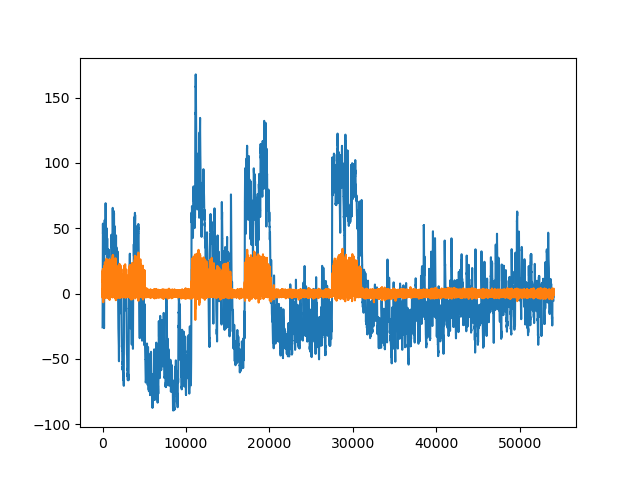

In [2555]:
plt.figure()
plt.plot(400*obs[:,0])
plt.plot(obs[:,1])
plt.show()

# Universal manifold

In [2565]:
#decoder.save('allen_pupil_decoder')
#encoder.save_weights("allen_pupil_encoder_weights.h5")
encoder.save_weights("test_encoder_weights.h5")

In [2979]:
num_bins = 100

lim = 1
xx,yy = np.meshgrid(np.linspace(-lim,lim,num_bins),np.linspace(-lim,lim,num_bins))


Z = np.zeros((num_bins,num_bins,7))
tic()
for i in range(num_bins): # col by col
    Z[:,i,:] = decoder.predict(np.vstack((xx[:,i],yy[:,i],0*yy[:,i])).T, verbose=False)[:,:7]
toc()

Elapsed time is 4.912849426269531 seconds.


In [3033]:
## ENSEMBLE PREDICTIONS
num_bins = 100

lim = 2
xx,yy = np.meshgrid(np.linspace(-lim,lim,num_bins),np.linspace(-lim,lim,num_bins))


Z = np.zeros((num_bins,num_bins,7))
tic()
j = 0
for d in decoders:
    print('Decoder ' + str(j+1) + '/' + str(len(decoders)))
    for i in range(num_bins): # col by col
        Z[:,i,:] = Z[:,i,:] + d.predict(np.vstack((0*yy[:,i],xx[:,i],yy[:,i])).T)[:,:7]
    j+=1
toc()


Decoder 1/72
Decoder 2/72
Decoder 3/72
Decoder 4/72
Decoder 5/72
Decoder 6/72
Decoder 7/72
Decoder 8/72
Decoder 9/72
Decoder 10/72
Decoder 11/72
Decoder 12/72
Decoder 13/72
Decoder 14/72
Decoder 15/72
Decoder 16/72
Decoder 17/72
Decoder 18/72
Decoder 19/72
Decoder 20/72
Decoder 21/72
Decoder 22/72
Decoder 23/72
Decoder 24/72
Decoder 25/72
Decoder 26/72
Decoder 27/72
Decoder 28/72
Decoder 29/72
Decoder 30/72
Decoder 31/72
Decoder 32/72
Decoder 33/72
Decoder 34/72
Decoder 35/72
Decoder 36/72
Decoder 37/72
Decoder 38/72
Decoder 39/72
Decoder 40/72
Decoder 41/72
Decoder 42/72
Decoder 43/72
Decoder 44/72
Decoder 45/72
Decoder 46/72
Decoder 47/72
Decoder 48/72
Decoder 49/72
Decoder 50/72
Decoder 51/72
Decoder 52/72
Decoder 53/72
Decoder 54/72
Decoder 55/72
Decoder 56/72
Decoder 57/72
Decoder 58/72
Decoder 59/72
Decoder 60/72
Decoder 61/72
Decoder 62/72
Decoder 63/72
Decoder 64/72
Decoder 65/72
Decoder 66/72
Decoder 67/72
Decoder 68/72
Decoder 69/72
Decoder 70/72
Decoder 71/72
Decoder 72/72
E

<IPython.core.display.Javascript object>


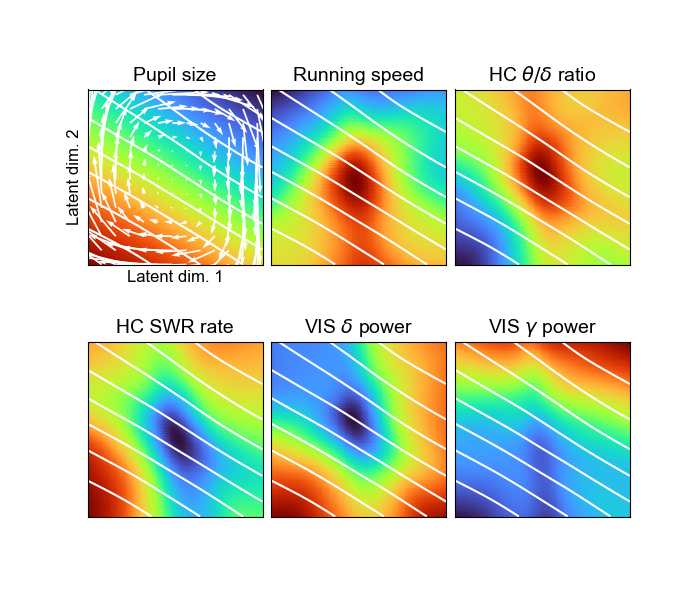

In [3034]:
plt.style.use('default')
#plt.style.use('dark_background')

#Z[:,:,2] = Z[:,:,6]
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2,3,figsize=(7, 6))
ax = ax.ravel()
fig.subplots_adjust(wspace=0.05)

titles = ['Pupil size', 'Running speed', r'HC $\theta/\delta$ ratio', 'HC SWR rate',
          'VIS $\delta$ power', 'VIS $\gamma$ power', r'$\alpha$ power']

for v in range(6):
    ax[v].grid(False)
    ax[v].axis('square')
    z = Z[:,:,v]
    p = ax[v].pcolormesh(xx, yy, z, edgecolors='face', cmap='turbo', vmin=np.min(z), vmax=np.max(z))
    
    levels = np.linspace(np.min(Z[:,:,0]), np.max(Z[:,:,0]), 10)
    ax[v].contour(xx, yy, Z[:,:,0], levels, colors='w', linestyles='solid')

    ax[v].set_xlim([-lim,lim])
    ax[v].set_ylim([-lim,lim])

    ax[v].set_xticks([])
    ax[v].set_yticks([])
    
    ax[v].set_title(titles[v], size=14,**afont)

ax[0].set_xlabel('Latent dim. 1', size=12, **{'fontname':'Arial'})
ax[0].set_ylabel('Latent dim. 2', size=12, **{'fontname':'Arial'})

# compute diffs
dx = np.zeros((num_bins,num_bins))
dy = dx.copy()

for i in range(num_bins): # col by col
    for j in range(num_bins):
        x = xx[i,j]
        y = yy[i,j]
        dx[i,j] = -.077*x*y + .123*y**3
        dy[i,j] = -.103*x - .154*x**3
        #dx[i,j] = .114*x*y**2 - .110*y**3
        #dy[i,j] = .066*x - .076*x*y**2

a = 8
ax[0].quiver(xx[::a,::a],yy[::a,::a],dx[::a,::a],dy[::a,::a], color='w', scale=3, width=0.01, angles='xy')

plt.show()

<IPython.core.display.Javascript object>


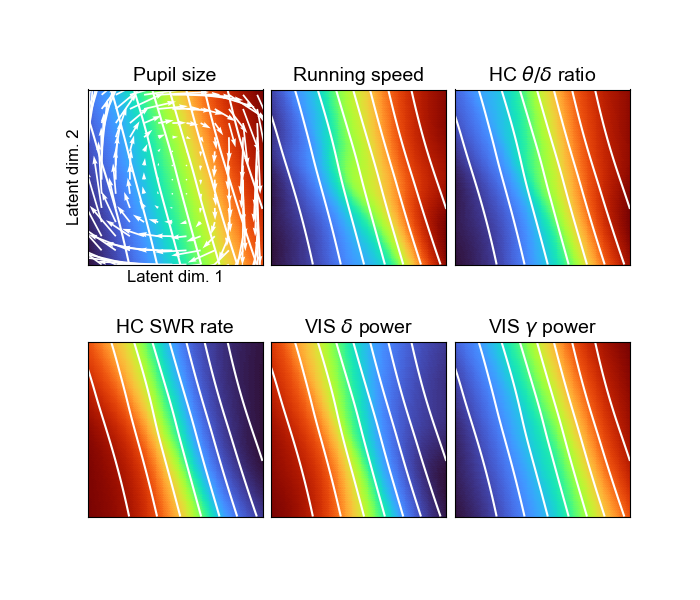

In [2998]:
plt.style.use('default')
#plt.style.use('dark_background')

#Z[:,:,2] = Z[:,:,6]
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2,3,figsize=(7, 6))
ax = ax.ravel()
fig.subplots_adjust(wspace=0.05)

titles = ['Pupil size', 'Running speed', r'HC $\theta/\delta$ ratio', 'HC SWR rate',
          'VIS $\delta$ power', 'VIS $\gamma$ power', r'$\alpha$ power']

for v in range(6):
    ax[v].grid(False)
    ax[v].axis('square')
    z = Z[:,:,v]
    p = ax[v].pcolormesh(xx, yy, z, edgecolors='face', cmap='turbo', vmin=np.min(z), vmax=np.max(z))
    
    levels = np.linspace(np.min(Z[:,:,0]), np.max(Z[:,:,0]), 10)
    ax[v].contour(xx, yy, Z[:,:,0], levels, colors='w', linestyles='solid')

    ax[v].set_xlim([-lim,lim])
    ax[v].set_ylim([-lim,lim])

    ax[v].set_xticks([])
    ax[v].set_yticks([])
    
    ax[v].set_title(titles[v], size=14,**afont)

ax[0].set_xlabel('Latent dim. 1', size=12, **{'fontname':'Arial'})
ax[0].set_ylabel('Latent dim. 2', size=12, **{'fontname':'Arial'})

# compute diffs
dx = np.zeros((num_bins,num_bins))
dy = dx.copy()

for i in range(num_bins): # col by col
    for j in range(num_bins):
        x = xx[i,j]
        y = yy[i,j]
        dx[i,j] = -.077*x*y + .123*y**3
        dy[i,j] = -.103*x - .154*x**3
        #dx[i,j] = .114*x*y**2 - .110*y**3
        #dy[i,j] = .066*x - .076*x*y**2

a = 8
ax[0].quiver(xx[::a,::a],yy[::a,::a],dx[::a,::a],dy[::a,::a], color='w', scale=3, width=0.01, angles='xy')

plt.show()

In [1477]:
#plt.savefig('temp.png', transparent=True, dpi=1200)

In [92]:
def scaler(data_in, scaler_in = None):

    if scaler_in is None:
        scaler_in = MinMaxScaler(feature_range=(-1, 1))
        #scaler_in.fit(data_in.flatten().reshape(-1,1))
        scaler_in.fit(data_in)
        
    #x = scaler_in.transform(data_in.flatten().reshape(-1,1)).reshape(data_in.shape)
    x = scaler_in.transform(data_in)
    x = StandardScaler(with_std=False).fit_transform(x)
    
    return x, scaler_in

In [93]:
def linear_regression(x,y):
    
    from sklearn.linear_model import LinearRegression

    L = LinearRegression()
    L.fit(x,y)
    y_hat = L.predict(x)
    r_squared = r2_score(y, y_hat, multioutput='variance_weighted')
    
    return r_squared, L

# SINDy

In [3040]:
dt = .05
thresholds = .2 * np.ones((10,2))
sr3_optimizer = ps.SR3(thresholder="weighted_l0", thresholds=thresholds)

# LASSO
lasso_optimizer = Lasso(alpha=.004, max_iter=2000, fit_intercept=False)

# Instantiate and fit the SINDy model
sindy = ps.SINDy(
    optimizer=ps.STLSQ(threshold=.15),
    #optimizer=sr3_optimizer,
    #optimizer=lasso_optimizer,
    differentiation_method=ps.SmoothedFiniteDifference(drop_endpoints=True),
    feature_library=ps.PolynomialLibrary(degree=3),
    #feature_names=['z1', 'z2', 'z3']
)
#temp = encoder.predict(xtrain)[0]
temp = model.predict(train_x).numpy()
sindy.fit(temp, t=dt)
sindy.print()

NotFittedError: This SINDy instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [2881]:
t = np.arange(0, 1000, dt)
z0 = temp[1000,:]
z_sim = sindy.simulate(z0, t)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1895297117734D+03   r2 =  0.1368148626112D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1895297117734D+03   r2 =  0.1368148626112D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1895297117734D+03   r2 =  0.1368148626112D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1895297117734D+03   r2 =  0.1368148626112D-13
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


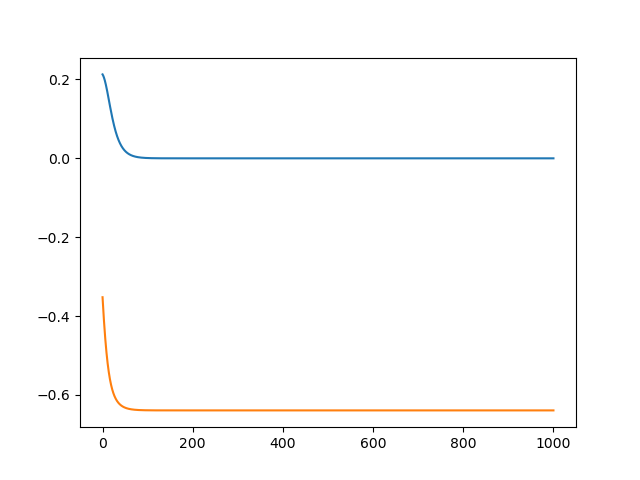

In [2598]:
fig, ax = plt.subplots()
plt.plot(t,z_sim)
plt.show()

<IPython.core.display.Javascript object>


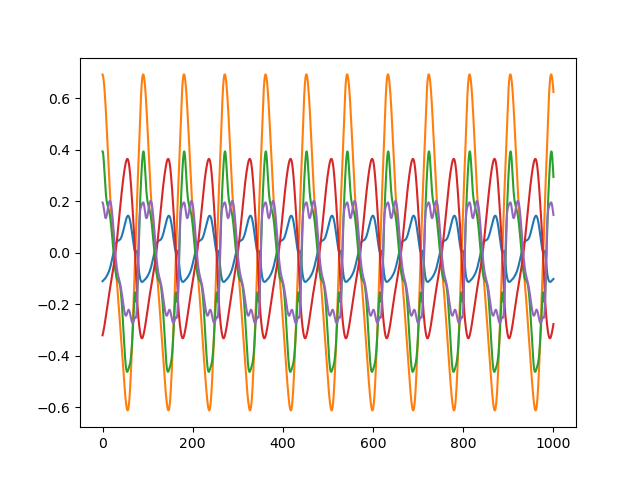

625/625 [==============================] - 1s 2ms/step


In [2097]:
fig, ax = plt.subplots()
plt.plot(t,decoder.predict(z_sim)[:,:5])
plt.show()

# All-to-all

## multimodal VAE

In [1923]:
def VAE_mm2(xtrain1, xtrain2, xtrain3, ytrain1, ytrain2, ytrain3, latent_dim=8, beta=.1):
    
    from keras import backend as K
    from keras import layers
    from keras.layers import Concatenate, Dense, Dropout, Input, Layer
        
    input_dim = xtrain1.shape[1]
    output_dim = ytrain1.shape[1]
    latent_dim = latent_dim
    
    input_data1 = keras.Input(shape=(input_dim,))
    input_data2 = keras.Input(shape=(input_dim,))
    input_data3 = keras.Input(shape=(input_dim,))
    input_data = [input_data1, input_data2, input_data3]
    
    class Sampling(Layer):
        """Uses (z_mean, z_log_var) to sample z"""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * .01*epsilon
    
    encoded1 = Dense(latent_dim, activation='linear')(input_data1)
    encoded2 = Dense(latent_dim, activation='linear')(input_data2)
    encoded3 = Dense(latent_dim, activation='linear')(input_data3)   
    #merged = Concatenate(axis=-1)([encoded1, encoded2, encoded3])
    #encoded = Dense(latent_dim, activation='tanh')(merged)
    
    z_mean1 = Dense(latent_dim, name="z_mean1")(encoded1)
    z_log_var1 = Dense(latent_dim, name="z_log_var1")(encoded1)
    z1 = Sampling()([z_mean1, z_log_var1])
    
    z_mean2 = Dense(latent_dim, name="z_mean2")(encoded2)
    z_log_var2 = Dense(latent_dim, name="z_log_var2")(encoded2)
    z2 = Sampling()([z_mean2, z_log_var2])
    
    z_mean3 = Dense(latent_dim, name="z_mean3")(encoded3)
    z_log_var3 = Dense(latent_dim, name="z_log_var3")(encoded3)
    z3 = Sampling()([z_mean3, z_log_var3])
    
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    decoded1 = Dense(latent_dim, activation='tanh')(latent_inputs)
    decoded1 = Dense(output_dim, activation='linear')(decoded1)
    
    decoded2 = Dense(latent_dim, activation='tanh')(latent_inputs)
    decoded2 = Dense(output_dim, activation='linear')(decoded2)
    
    decoded3 = Dense(latent_dim, activation='tanh')(latent_inputs)
    decoded3 = Dense(output_dim, activation='linear')(decoded3)
    
    # define models    
    #encoder = keras.Model(input_data, [z_mean, z_log_var, z], name="encoder")
    encoder1 = keras.Model(input_data1, [z_mean1, z_log_var1, z1], name="encoder1")
    encoder2 = keras.Model(input_data2, [z_mean2, z_log_var2, z2], name="encoder2")
    encoder3 = keras.Model(input_data3, [z_mean3, z_log_var3, z3], name="encoder3")
    decoder1 = keras.Model(latent_inputs, decoded1, name="decoder1")
    decoder2 = keras.Model(latent_inputs, decoded2, name="decoder2")
    decoder3 = keras.Model(latent_inputs, decoded3, name="decoder3")
    
    
    class VAE_mm2(keras.Model):
        def __init__(self, encoder1, encoder2, encoder3, decoder1, decoder2, decoder3, **kwargs):
            super(VAE_mm2, self).__init__(**kwargs)
            #self.encoder = encoder
            self.encoder1 = encoder1
            self.encoder2 = encoder2
            self.encoder3 = encoder3
            self.decoder1 = decoder1
            self.decoder2 = decoder2
            self.decoder3 = decoder3

            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            
            data0, data123 = data
            data_a, data_b, data_c = data0
            data1, data2, data3 = data123
            
            
            with tf.GradientTape() as tape:
                
                ### 1
                z_mean1, z_log_var1, z1 = self.encoder1(data_a)
                
                reconstruction1 = self.decoder1(z1)
                reconstruction_loss1 = tf.reduce_mean(keras.losses.mse(data1, reconstruction1),0)
                reconstruction2 = self.decoder2(z1)
                reconstruction_loss2 = tf.reduce_mean(keras.losses.mse(data2, reconstruction2),0)
                reconstruction3 = self.decoder3(z1)
                reconstruction_loss3 = tf.reduce_mean(keras.losses.mse(data3, reconstruction3),0)
                reconstruction_loss = reconstruction_loss1 + reconstruction_loss2 + reconstruction_loss3
                kl_loss = -0.5 * (1 + z_log_var1 - tf.square(z_mean1) - tf.exp(z_log_var1))
                kl_loss = tf.reduce_mean(kl_loss,0)
                total_loss1 = reconstruction_loss + beta*kl_loss
                
                ## 2
                z_mean2, z_log_var2, z2 = self.encoder2(data_b)
                reconstruction1 = self.decoder1(z2)
                reconstruction_loss1 = tf.reduce_mean(keras.losses.mse(data1, reconstruction1),0)
                reconstruction2 = self.decoder2(z2)
                reconstruction_loss2 = tf.reduce_mean(keras.losses.mse(data2, reconstruction2),0)
                reconstruction3 = self.decoder3(z2)
                reconstruction_loss3 = tf.reduce_mean(keras.losses.mse(data3, reconstruction3),0)
                reconstruction_loss = reconstruction_loss1 + reconstruction_loss2 + reconstruction_loss3
                kl_loss = -0.5 * (1 + z_log_var2 - tf.square(z_mean2) - tf.exp(z_log_var2))
                kl_loss = tf.reduce_mean(kl_loss,0)
                
                total_loss2 = reconstruction_loss + beta*kl_loss
                
                ## 3
                z_mean3, z_log_var3, z3 = self.encoder3(data_c)
                reconstruction1 = self.decoder1(z3)
                reconstruction_loss1 = tf.reduce_mean(keras.losses.mse(data1, reconstruction1),0)
                reconstruction2 = self.decoder2(z3)
                reconstruction_loss2 = tf.reduce_mean(keras.losses.mse(data2, reconstruction2),0)
                reconstruction3 = self.decoder3(z3)
                reconstruction_loss3 = tf.reduce_mean(keras.losses.mse(data3, reconstruction3),0)
                reconstruction_loss = reconstruction_loss1 + reconstruction_loss2 + reconstruction_loss3
                kl_loss = -0.5 * (1 + z_log_var3 - tf.square(z_mean3) - tf.exp(z_log_var3))
                kl_loss = tf.reduce_mean(kl_loss,0)
                
                total_loss3 = reconstruction_loss + beta*kl_loss
                
                
                total_loss = total_loss1 + total_loss2 + total_loss3
                        
                
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
        
        def predict(self, data):
            #data1, data2, data3 = data
            #data = [data1, data2, data3]
            z_mean,_,z_sample = self.encoder(data)
            decoded1 = self.decoder1(z_mean)
            decoded2 = self.decoder2(z_mean)
            decoded3 = self.decoder3(z_mean)
            return decoded1, decoded2, decoded3
            
    vae_mm = VAE_mm2(encoder1, encoder2, encoder3, decoder1, decoder2, decoder3)
    opt = keras.optimizers.Adam(learning_rate=.02)
    vae_mm.compile(optimizer=opt)
    
    vae_mm.fit([xtrain1, xtrain2, xtrain3], [ytrain1, ytrain2, ytrain3], epochs=200, batch_size=1000)
        
    #r_squared = r2_score(ytrain, vae.predict(xtrain), multioutput = 'variance_weighted')
    
    return vae_mm, encoder1, encoder2, encoder3, decoder1, decoder2, decoder3

In [1924]:
stackmax = 50#200
spacing = 6
nsamples = 27000
Fs = 30

y = ratio
#y[:,0] = delta_mean
#y[:,1] = gamma_mean
#y[:,2] = ripple_rate

sos = signal.butter(2, [.005,.2], btype = 'bandpass', output = 'sos', fs = 30)
y = signal.sosfiltfilt(sos, y, axis=0)

def hankelize(Xin):
    
    H = hankel_matrix(Xin.T,stackmax,spacing)
    Hu, Hs, Hvh = np.linalg.svd(H, full_matrices=False)
    
    polys = true_polys(stackmax, 1/Fs, 3, center=False)
    H_out = (polys.T@H).T

    # scale
    #H_out = np.diag(Hs)@Hvh
    #H_out = H_out[:3,:].T

    return H_out

x1 = hankelize(y[:,0].reshape(-1,1))
x2 = hankelize(y[:,1].reshape(-1,1))
x3 = hankelize(y[:,2].reshape(-1,1))

xtrain1 = x1[:nsamples,:]
xtrain2 = x2[:nsamples,:]
xtrain3 = x3[:nsamples,:]

y = y[spacing*(stackmax-1):,:]
ytrain1 = y[:nsamples,0].reshape(-1,1)
ytrain2 = y[:nsamples,1].reshape(-1,1)
ytrain3 = y[:nsamples,2].reshape(-1,1)

#ytrain1 = x1[:nsamples,:]
#ytrain2 = x2[:nsamples,:]
#ytrain3 = x3[:nsamples,:]

In [1925]:
xtrain1, scale_x1 = scaler(xtrain1)
xtrain2, scale_x2 = scaler(xtrain2)
xtrain3, scale_x3 = scaler(xtrain3)

ytrain1, scale_y1 = scaler(ytrain1)
ytrain2, scale_y2 = scaler(ytrain2)
ytrain3, scale_y3 = scaler(ytrain3)

In [1926]:
model, encoder1, encoder2, encoder3, decoder1, decoder2, decoder3 = VAE_mm2(
    xtrain1, xtrain2, xtrain3, ytrain1, ytrain2, ytrain3, latent_dim=6, beta=.1)

Epoch 1/200
27/27 [==============================] - 1s 9ms/step - loss: 0.7640 - reconstruction_loss: 0.1899 - kl_loss: 0.0119
Epoch 2/200
27/27 [==============================] - 0s 9ms/step - loss: 0.4228 - reconstruction_loss: 0.1310 - kl_loss: 0.0150
Epoch 3/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3927 - reconstruction_loss: 0.1296 - kl_loss: 0.0158
Epoch 4/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3871 - reconstruction_loss: 0.1287 - kl_loss: 0.0162
Epoch 5/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3909 - reconstruction_loss: 0.1275 - kl_loss: 0.0158
Epoch 6/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3809 - reconstruction_loss: 0.1274 - kl_loss: 0.0151
Epoch 7/200
27/27 [==============================] - 0s 10ms/step - loss: 0.3864 - reconstruction_loss: 0.1275 - kl_loss: 0.0148
Epoch 8/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3799 - reconstruction_loss: 

27/27 [==============================] - 0s 9ms/step - loss: 0.3422 - reconstruction_loss: 0.1126 - kl_loss: 0.0283
Epoch 128/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3418 - reconstruction_loss: 0.1120 - kl_loss: 0.0279
Epoch 129/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3435 - reconstruction_loss: 0.1121 - kl_loss: 0.0279
Epoch 130/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3373 - reconstruction_loss: 0.1120 - kl_loss: 0.0267
Epoch 131/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3449 - reconstruction_loss: 0.1121 - kl_loss: 0.0280
Epoch 132/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3381 - reconstruction_loss: 0.1113 - kl_loss: 0.0277
Epoch 133/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3392 - reconstruction_loss: 0.1116 - kl_loss: 0.0274
Epoch 134/200
27/27 [==============================] - 0s 9ms/step - loss: 0.3421 - reconstruction_loss:

In [1927]:
#ytrain1_hat, ytrain2_hat, ytrain3_hat = model.predict([ytrain1,ytrain2,ytrain3])
latent,_,_ = encoder3(xtrain3)
ytrain1_hat = decoder1(latent)
r2_score(ytrain1[:,0], ytrain1_hat[:,0], multioutput = 'variance_weighted')

0.3695252078948422

In [1928]:
y.shape

(53687, 6)

In [1929]:
# HELD OUT DATA
nsamples2 = nsamples + 1000
xtest1,_ = scaler(x1[nsamples2:,:], scale_x1)
xtest2,_ = scaler(x2[nsamples2:,:], scale_x2)
xtest3,_ = scaler(x3[nsamples2:,:], scale_x3)

#ytest1,_ = scaler(x1[nsamples2:,:], scale_y1)
#ytest2,_ = scaler(x2[nsamples2:,:], scale_y2)
#ytest3,_ = scaler(x3[nsamples2:,:], scale_y3)

ytest1,_ = scaler(y[nsamples2:,0].reshape(-1,1), scale_y1)
ytest2,_ = scaler(y[nsamples2:,1].reshape(-1,1), scale_y2)
ytest3,_ = scaler(y[nsamples2:,2].reshape(-1,1), scale_y3)

In [1930]:
latent,_,_ = encoder2(xtest2)
ytest3_hat = decoder3(latent)

r2_score(ytest3[:,0], ytest3_hat[:,0], multioutput = 'variance_weighted')

0.22017330637985355

In [1931]:
#ytest1 = scale_y1.inverse_transform(ytest1)
#ytest1_hat = scale_y1.inverse_transform(ytest1_hat)
#ytest2 = scale_y2.inverse_transform(ytest2)
#ytest2_hat = scale_y2.inverse_transform(ytest2_hat)
#ytest3 = scale_y3.inverse_transform(ytest3)
#ytest3_hat = scale_y3.inverse_transform(ytest3_hat)

<IPython.core.display.Javascript object>


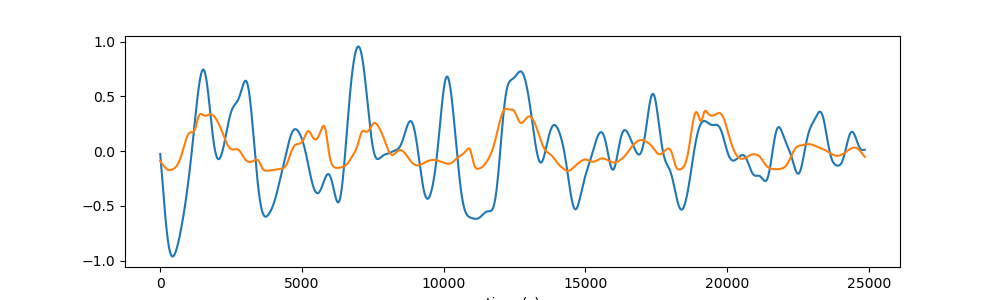

In [1000]:
t = np.arange(0, ytest3.shape[0]/30, 1/30)

fig, ax = plt.subplots(figsize=(10,3))
plt.plot(ytest3[:,0])
plt.plot(ytest3_hat[:,0])
plt.xlabel("time (s)")
plt.show()

In [1932]:
dict_encoders = {
    "1": encoder1,
    "2": encoder2,
    "3": encoder3,
}

dict_decoders = {
    "1": decoder1,
    "2": decoder2,
    "3": decoder3,
}

xtest = [xtest1,xtest2,xtest3]
ytest = [ytest1,ytest2,ytest3]

In [1933]:
r_sqrs = np.ones((3,3))

for i, encoder in dict_encoders.items():
    for j, decoder in dict_decoders.items():
        
        latent,_,_ = encoder(xtest[int(i)-1])
        y_hat = decoder(latent)
        
        r_sqrs[int(i)-1,int(j)-1] = r2_score(ytest[int(j)-1][:,0], y_hat[:,0], multioutput = 'variance_weighted')

<IPython.core.display.Javascript object>


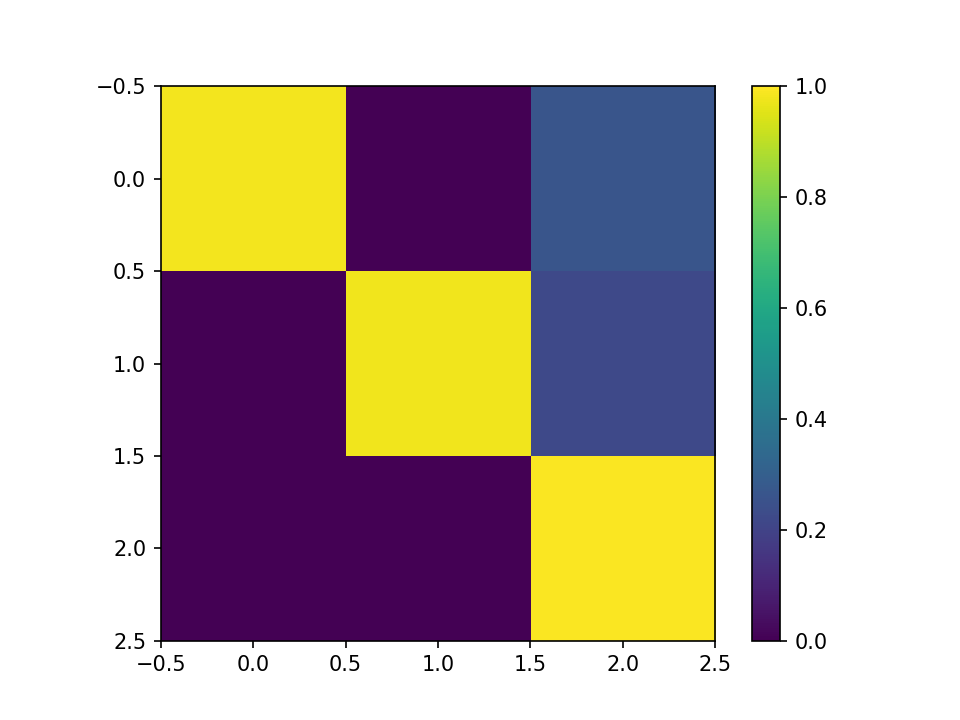

In [1934]:
plt.figure()
plt.imshow(r_sqrs,cmap='viridis',vmin=0,vmax=1)
plt.colorbar()
plt.show()

In [1935]:
r_sqrs

array([[ 0.98288323, -0.16842695,  0.26224618],
       [-0.41558218,  0.9786012 ,  0.22017331],
       [-0.65741001, -0.01674988,  0.99307499]])

<IPython.core.display.Javascript object>


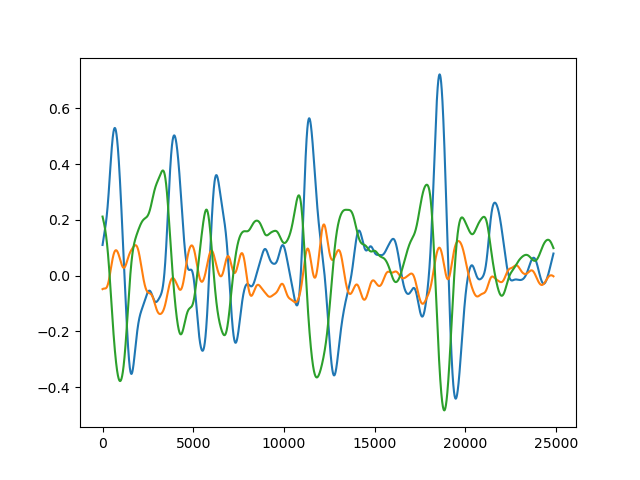

In [1006]:
plt.figure()
plt.plot(latent[:,0])
plt.plot(latent[:,1])
plt.plot(latent[:,2])

<IPython.core.display.Javascript object>


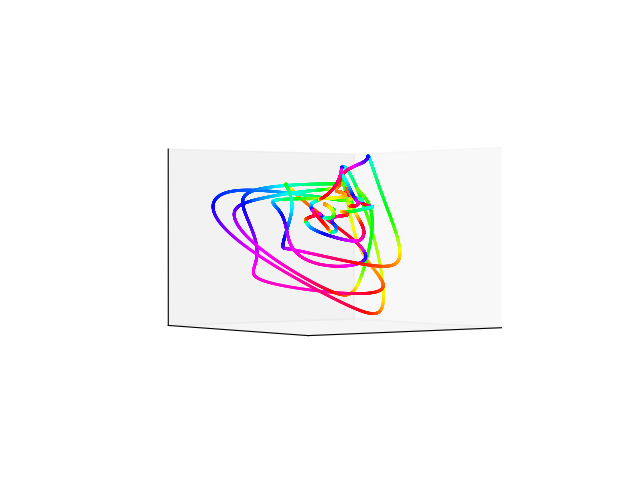

In [1009]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(latent[:lim,0],latent[:lim,1],latent[:lim,2],s=1,c=colors[-24860:],cmap='hsv')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()


# Phase portraits

<IPython.core.display.Javascript object>


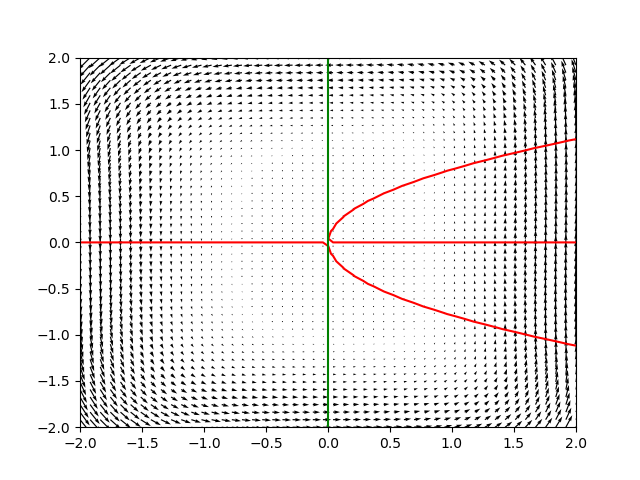

In [1432]:
tau   = 2
I_ext = 0.5
a     = 0.8
b     = 0.7

def model(x, t = 0):
    'FitzHugh–Nagumo model'
    V, W = x
    #dV = V - V**3/3 - W + I_ext
    #dW = (V + a - b * W) / tau
    
    dV = .077*V*W - .123*W**3
    dW = .103*V + .154*V**3
    return np.array([dV, dW])

def phase_plane_plot(model, range_x = (-1,1), range_y = None,
                     num_grid_points = 50, show = False):
    '''
    Simple implementation of the phase plane plot in matplotlib.
    
    Input:
    -----
      *model* : function
        function that takes numpy.array as input with two elements
        representing two state variables
      *range_x* = (-1, 1) : tuple
        range of x axis
      *range_y* = None : tuple
        range of y axis; if None, the same range as *range_x*
      *num_grid_points* = 50 : int
        number of samples on grid
      *show* = False : bool
        if True it shows matplotlib plot
    '''
    if range_y is None:
        range_y = range_x
    x_ = np.linspace(range_x[0], range_x[1], num_grid_points)                                                             
    y_ = np.linspace(range_y[0], range_y[1], num_grid_points)                                                             

    grid = np.meshgrid(x_, y_)

    dfmat = np.zeros((num_grid_points, num_grid_points, 2))
    for nx in range(num_grid_points):
        for ny in range(num_grid_points):
            df = model([grid[0][nx,ny], grid[1][nx,ny]])
            dfmat[nx, ny, 0] = df[0]
            dfmat[nx, ny, 1] = df[1]


    plt.quiver(grid[0], grid[1], dfmat[:, :, 0], dfmat[:, :, 1])
    plt.contour(grid[0], grid[1], dfmat[:, :, 0], [0], colors = 'r')
    plt.contour(grid[0], grid[1], dfmat[:, :, 1], [0], colors = 'g')
    if show:
        plt.show()

if __name__ == "__main__":
    phase_plane_plot(model, range_x = (-2, 2), show = True)